In [904]:
import os
import numpy as np
import torch as T
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats


%store -r CapIQ_data_dict_FY_N
%store -r L

%store -r ID_Green
%store -r ID_Red
%store -r ID_Blue
%store -r ID_Magenta

In [732]:
x = np.array([0.258, 0.23,  0.238, 0.241])     
y = np.array([0.44, 0.101, 0.101, 0.101])  

c = np.corrcoef(x,y)
print(c[0][1])

0.9191469054472423


In [ ]:
0.352

In [875]:
file_errors_location = 'NAICS_to_Assumption_ID.xlsx'

def Scenario_NAICS(file):
    df = pd.read_excel(file)
    
    S_NAICS = {}
    for i in range(7,len(df)):
        if df.loc[i,"Unnamed: 11"] != 'Not Covered':
            if df.loc[i,"Unnamed: 11"] in S_NAICS.keys():
                S_NAICS[df.loc[i,"Unnamed: 11"]].add(df.loc[i,"Unnamed: 8"])
            else:
                S_NAICS[df.loc[i,"Unnamed: 11"]] = set([df.loc[i,"Unnamed: 8"]])
            
    
    return S_NAICS
        
    
Scenario_NAICS_Dict = Scenario_NAICS('NAICS_to_Assumption_ID.xlsx')
print(len(Scenario_NAICS_Dict))

269


In [903]:
def Get_Sector_Data_Dict(scenario,CapIQ_data_dict_FY_N):
    
    test_dict = {}
    for i in CapIQ_data_dict_FY_N.items():
        ID,data = i
        
        for j in scenario:
            if data['Sector'] == str(j):
                test_dict[ID] = data
            
    sector_rev_avg = np.zeros(5)
    for i in test_dict.items():
        ID,data = i
        sector_rev_avg += np.array(data['Revenue'])
        
    sector_avg_rev = np.round((sector_rev_avg/len(test_dict.items())),3)
    
    Sector_Data_Dict = {}
    Sector_Data_Dict['Scenario'] = scenario
    Sector_Data_Dict['Scenario_Rev'] = sector_avg_rev

    
    for i in test_dict.items():
        ID,data = i
        if len(set(data['Revenue'][0:4])) != 1:
            Sector_Data_Dict[ID] = {'Revenue' : data['Revenue'][0:4], 'Revenue Forecast' : data['Revenue'][4]}
            
    
    return Sector_Data_Dict

Scenario_Data_Dict = Get_Sector_Data_Dict(['2111'],CapIQ_data_dict_FY_N)
    
for i in Scenario_Data_Dict.items():
    print(i)
print(len(Scenario_Data_Dict.items()))

('Scenario', ['2111'])
('Scenario_Rev', array([0.309, 0.329, 0.352, 0.367, 0.385]))
('00613da5-508a-5e78-8a45-269f0b741ff4', {'Revenue': [0.493, 0.548, 0.601, 0.617], 'Revenue Forecast': 0.633})
('022625a0-8352-5214-b871-1db449cd0bb9', {'Revenue': [0.15, 0.123, 0.113, 0.116], 'Revenue Forecast': 0.117})
('0360ee5d-92b8-50e3-b21a-84da89900140', {'Revenue': [0.265, 0.321, 0.325, 0.347], 'Revenue Forecast': 0.35})
('03e8d086-f1f6-5080-98d4-c477fa20513a', {'Revenue': [0.324, 0.352, 0.399, 0.45], 'Revenue Forecast': 0.542})
('06102f1c-81cd-58f7-b993-e3194b93874a', {'Revenue': [0.374, 0.374, 0.381, 0.407], 'Revenue Forecast': 0.409})
('065fde3b-33b1-50bc-b61f-b16d0e4bc9b4', {'Revenue': [0.521, 0.542, 0.565, 0.559], 'Revenue Forecast': 0.575})
('07166888-e2b7-5d54-8e08-0a4936aefd39', {'Revenue': [0.326, 0.334, 0.337, 0.328], 'Revenue Forecast': 0.33})
('07da2ecb-fa24-55e1-bbaa-f974976b1172', {'Revenue': [0.111, 0.1, 0.1, 0.1], 'Revenue Forecast': 0.1})
('0832bd94-74e4-5a76-a186-014832bbba72',

In [880]:
def Get_the_Forecast(Sector_Data_Dict):
    
    n = 0
    Rev_Forecast = {}
    for i in Sector_Data_Dict.items():
        if n > 1:
            ID,data = i
            corr = round(np.corrcoef(Sector_Data_Dict['Scenario_Rev'][0:4],data['Revenue'])[0][1],3)
            
            #print(ID,'corr',corr,'data[3]', data['Revenue'][3])

            if data['Revenue'][3] - 0.3 <= 0:
                low_limit = 0
            else:
                low_limit = data['Revenue'][3] - 0.3

            if data['Revenue'][3] + 0.3 >= 1.7:
                up_limit = 1.7
            else:
                up_limit = data['Revenue'][3] + 0.3

            Rev_Forecast[ID] = []
            for j in np.arange(low_limit, up_limit, 0.0001):
                rev = np.append(data['Revenue'],j)
                new_corr = round(np.corrcoef(Sector_Data_Dict['Scenario_Rev'],rev)[0][1],3)
                #print(corr*1000,new_corr*1000,'j',round(j,4))
                if new_corr*1000 in range(int(corr*1000) - 40,int(corr*1000) + 40):
                    #print("Yes!")
                    if [round(abs(corr-new_corr),5),round(j,5)] not in Rev_Forecast[ID]:
                        Rev_Forecast[ID].append([round(abs(new_corr - corr),5),round(j,5),round(corr,5)])

        n += 1
        
        
    return Rev_Forecast
    
#Forecasted_Revenue = Get_the_Forecast(Scenario_Data_Dict)

In [881]:
def Get_Avg_Error(Forecasted_Revenue,Sector_Data_Dict):
    error = 0
    n = 0
    Forecast_Data_Dict = {}
    Forecast_Data_Dict['Sector'] = Sector_Data_Dict['Scenario']
    Forecast_Data_Dict['Sector Revenue'] = Sector_Data_Dict['Scenario_Rev']
    for i in Forecasted_Revenue.items():
        ID,val  = i
        #print(ID)
        Forecast_Data_Dict[ID] = {'Company Revenue':Sector_Data_Dict[ID]['Revenue'],'Actual':[Sector_Data_Dict[ID]['Revenue Forecast']],
                                 'Computed Forecast':[val[0][1]]}
        if Sector_Data_Dict[ID]['Revenue Forecast'] != 0:
            val = np.array(val)
            #print(val)
            val = val[val[:,0].argsort()]
            ind = abs(val - [0,Sector_Data_Dict[ID]['Revenue'][3],0])
            val = val[ind[:,1][:100].argsort()]
            #print(val)
            current_err = round(abs(Sector_Data_Dict[ID]['Revenue Forecast'] - val[0][1])/Sector_Data_Dict[ID]['Revenue Forecast'],5)
            
#             if current_err > 0.25:
#                 print('Sector',Sector_Data_Dict['Scenario'],'Sector Revenue' ,Sector_Data_Dict['Scenario_Rev'],'Correlation ',val[0][2])
#                 print(ID,'Company_Rev ',Sector_Data_Dict[ID]['Revenue'],'R5 ',Sector_Data_Dict[ID]['Revenue Forecast']," Computed ", val[0][1], "Error ",current_err,'\n')

            error += current_err
        else:
            error += abs(0.01 - val[0][1])/0.01
        n += 1

    error = round(error/n,3)

    print(n,"Avg Error ",error)
    
    return error,Forecast_Data_Dict

#avg_error,Forecast_Data_Dict = Get_Avg_Error(Forecasted_Revenue,Scenario_Data_Dict)
    
#print(len(Forecasted_Revenue.items()))

In [882]:
def Total_Avg_Error(Scenario_NAICS_Dict):
    L = []
    scenario_error = {}
    total_avg_error = 0
    n = 0
    for i in Scenario_NAICS_Dict.items():
        key,val = i
        Scenario_Data_Dict = Get_Sector_Data_Dict(Scenario_NAICS_Dict[key],CapIQ_data_dict_FY_N)
        if len(Scenario_Data_Dict) > 3:
            
            print("Scenario ",key,val)
            Forecasted_Revenue = Get_the_Forecast(Scenario_Data_Dict)
            avg_error,Forecast_Data_Dict = Get_Avg_Error(Forecasted_Revenue,Scenario_Data_Dict)
            
            scenario_error[key] = avg_error
            total_avg_error += avg_error
            L.append(avg_error)
            n += 1
    print("Total Avg Error ",total_avg_error)
    
    return total_avg_error/n,n,scenario_error,L
        
total_avg_error,n,scenario_error_dict,L = Total_Avg_Error(Scenario_NAICS_Dict)

Scenario  306 {111211, 111411, 111219, 111130, 111419, 111421, 111422}
3 Avg Error  0.094
Scenario  176 {111331, 111332, 111333, 111334, 111335, 111336, 111339, 111310, 111320}
4 Avg Error  0.03
Scenario  211 {111940, 111910, 111920, 111991, 111992, 111930, 111998}
3 Avg Error  0.133
Scenario  5 {112320, 112390, 112330, 112340, 112310}


/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


2 Avg Error  0.034
Scenario  6 {112512, 112519, 112511}
2 Avg Error  0.046
Scenario  94 {115310, 113210, 113310, 113110}
3 Avg Error  0.006
Scenario  8 {211120, 211130}
21 Avg Error  0.294
Scenario  95 {325920, 212291, 212111, 212112, 212113, 213113}
21 Avg Error  0.062
Scenario  299 {212221}
18 Avg Error  0.062
Scenario  69 {213114, 331491, 331492, 212230}
13 Avg Error  0.062
Scenario  26 {332322, 331210, 212299, 331221, 331222}
22 Avg Error  0.023
Scenario  9 {212321, 212322, 327992, 212324, 212325, 327993, 212399, 335991, 212311, 212312, 212313, 213115, 327420, 212319}
9 Avg Error  0.015
Scenario  297 {212392, 212393, 212391}
6 Avg Error  0.041
Scenario  178 {213111}
23 Avg Error  0.06
Scenario  70 {213112}
63 Avg Error  0.088
Scenario  10 {221121, 221122, 221111, 221112, 221113, 221114, 221115, 221116, 221117, 221118}
94 Avg Error  0.042
Scenario  338 {221210}
77 Avg Error  0.033
Scenario  71 {221320, 221330, 221310}
25 Avg Error  0.12
Scenario  11 {236115, 236116, 236117}
25 Avg E

8 Avg Error  0.014
Scenario  154 {424480, 424450, 424420, 424490, 424460, 424430, 424470, 424440, 424410, 424990}
18 Avg Error  0.1
Scenario  167 {424520, 424590, 424510}
3 Avg Error  0.038
Scenario  42 {424690, 424610}
3 Avg Error  0.021
Scenario  262 {424720, 454310, 424710}
32 Avg Error  0.107
Scenario  46 {424810, 424820, 445310}
3 Avg Error  0.224
Scenario  123 {424910}
3 Avg Error  0.009
Scenario  255 {424920, 451211, 451212}
5 Avg Error  0.01
Scenario  52 {424930, 453220, 453210, 453110}
10 Avg Error  0.01
Scenario  45 {444130, 444110, 424950, 444120, 444190}
4 Avg Error  0.019
Scenario  53 {454110, 425110}
44 Avg Error  0.206
Scenario  252 {441210, 441222}
5 Avg Error  0.03
Scenario  43 {442210, 442110, 442291, 442299, 453310}
11 Avg Error  0.027
Scenario  44 {443141, 443142}
14 Avg Error  0.053
Scenario  107 {445120, 454210, 445220, 445291, 445292, 445230, 445299, 445110, 454390, 445210}
35 Avg Error  0.039
Scenario  47 {446120, 446191, 446130, 446199, 446110}
28 Avg Error  0.

In [884]:
print(total_avg_error)

0.07111111111111108


In [897]:
L = [0.01,0.01,0.099,0.068,0.033,0.051,0.023,0.046,0.072,0.045,0.022,0.042,0.085,0.096,0.144,0.016,0.08,0.209,0.136,0.069,0.079,
    0.045,0.146,0.033,0.089,0.064,0.062,0.04,0.008,0.042,0.059,0.019,0.041,0.09,0.08,0.099,0.069,0.183,0.046,0.128,0.095,0.085,
    0.172,0.078,0.093,0.098,0.147,0.044,0.041,0.042,0.082,0.034,0.033,0.03,0.094,0.108,0.073,0.112,0.109,0.116,0.097,0.046,
     0.043,0.35,0.034,0.134,0.4,0.105,0.055,0.036,0.105,0.056,0.053,0.081,0.009,0.006,0.044,0.019,0.007,0.041,0.014,0.08,0.03,
    0.026,0.021,0.36,0.039,0.053,0.027,0.03,0.206,0.019,0.01,0.01,0.009,0.224,0.107,0.021,0.038,0.1,0.014,0.043,0.075,0.064,0.029,
    0.032,0.021,0.012,0.047,0.049,0.036,0.122,0.046,0.062,0.042,0.035,0.071,0.077,0.014,0.028,0.094,0.024,0.077,0.02,0.081,
    0.081,0.032,0.074,0.068,0.042,0.075,0.111,0.518,0.102,0.11,0.103,0.136,0.079,0.097,0.093,0.107,0.096,0.073,0.022,0.039,
    0.053,0.058,0.015,0.079,0.07,0.062,0.124,0.073,0.117,0.045,0.036,0.048,0.419,0.066,0.036,0.164,0.071,0.046,0.178,0.29,0.11,0.15,0.05,
    0.016,0.064,0.043,0.049,0.012,0.016,0.062,0.027,0.067,0.032,0.302,0.025,0.062,0.064,0.028,0.159,0.032,0.051,0.039,0.023,0.029,
     0.061,0.071,0.088,0.048,0.037,0.041,0.021,0.024,0.135,0.088,0.037,0.011,0.066,0.031,0.016,0.103,0.044,0.12,0.033,0.042,0.088,
    0.06,0.041,0.015,0.023,0.062,0.062,0.062,0.294,0.006,0.046,0.034,0.133,0.03,0.094]

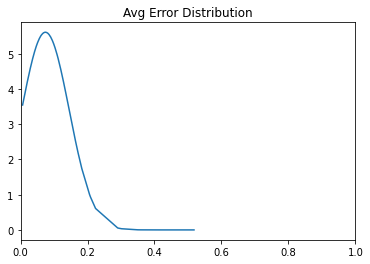

In [902]:
L.sort()
fit = stats.norm.pdf(L, np.mean(L), np.std(L))  #this is a fitting indeed

plt.xlim(0,1)
plt.plot(L,fit)
plt.title("Avg Error Distribution")
plt.show() 

In [ ]:
print(np.std(L))

In [905]:
def Get_Sector_Data_Dict_Demo(scenario,CapIQ_data_dict_FY_N):
    
    test_dict = {}
    for i in CapIQ_data_dict_FY_N.items():
        ID,data = i
        
        for j in scenario:
            if data['Sector'] == str(j):
                test_dict[ID] = data
            
    sector_rev_avg = np.zeros(5)
    for i in test_dict.items():
        ID,data = i
        sector_rev_avg += np.array(data['Revenue'])
        
    sector_avg_rev = np.round((sector_rev_avg/len(test_dict.items())),3)
    
    Sector_Data_Dict = {}
    Sector_Data_Dict['Scenario'] = scenario
    Sector_Data_Dict['Scenario_Rev'] = sector_avg_rev

    
    for i in test_dict.items():
        ID,data = i
        if len(set(data['Revenue'][0:5])) != 1:
            Sector_Data_Dict[ID] = {'Revenue' : data['Revenue'][0:5]}
            
    
    return Sector_Data_Dict

Scenario_Data_Dict_Demo = Get_Sector_Data_Dict_Demo(['2111'],CapIQ_data_dict_FY_N)

m = 0
for i in Scenario_Data_Dict_Demo.items():
    print(i)
    if m > 5:
        break
    m += 1
print(len(Scenario_Data_Dict_Demo.items()))

('Scenario', ['2111'])
('Scenario_Rev', array([0.309, 0.329, 0.352, 0.367, 0.385]))
('00613da5-508a-5e78-8a45-269f0b741ff4', {'Revenue': [0.493, 0.548, 0.601, 0.617, 0.633]})
('022625a0-8352-5214-b871-1db449cd0bb9', {'Revenue': [0.15, 0.123, 0.113, 0.116, 0.117]})
('0360ee5d-92b8-50e3-b21a-84da89900140', {'Revenue': [0.265, 0.321, 0.325, 0.347, 0.35]})
('03e8d086-f1f6-5080-98d4-c477fa20513a', {'Revenue': [0.324, 0.352, 0.399, 0.45, 0.542]})
('06102f1c-81cd-58f7-b993-e3194b93874a', {'Revenue': [0.374, 0.374, 0.381, 0.407, 0.409]})
265


In [806]:
# print(ID_Green)

In [906]:
def Get_Category_Rev_Avg(ID_Green,ID_Red,ID_Blue,ID_Magenta,Scenario_Data_Dict_Demo):
    
    Green = np.array([0.,0.,0.,0.,0.])
    Red = np.array([0.,0.,0.,0.,0.])
    Blue = np.array([0.,0.,0.,0.,0.])
    Magenta = np.array([0.,0.,0.,0.,0.])
    
    m = p = q = r = 0

    for i in Scenario_Data_Dict_Demo.items():
        ID,data = i
        if ID in ID_Green:
            Green += np.array(data['Revenue'])
            m += 1
        if ID in ID_Blue:
            Blue += np.array(data['Revenue'])
            p += 1
        if ID in ID_Magenta:
            Magenta += np.array(data['Revenue'])
            q += 1
        if ID in ID_Red:
            Red += np.array(data['Revenue'])
            r += 1
            
            
    return (np.round_(Green/m,4)), (np.round_(Blue/p,4)), (np.round_(Magenta/q,4)), (np.round_(Red/r,4)) 

Green_Rev,Blue_Rev,Magenta_Rev,Red_Rev = Get_Category_Rev_Avg(ID_Green,ID_Red,ID_Blue,ID_Magenta,Scenario_Data_Dict_Demo)

In [955]:
Category_Data_Dict = {'Sector' : Scenario_Data_Dict_Demo['Scenario'],
                     'Sector_Rev' : Scenario_Data_Dict_Demo['Scenario_Rev'],
                     'Green' : Green_Rev,
                     'Blue' : Blue_Rev,
                     'Magenta' : Magenta_Rev,
                     'Red' : Red_Rev}
print(Category_Data_Dict)

{'Sector': ['2111'], 'Sector_Rev': array([0.309, 0.329, 0.352, 0.367, 0.385]), 'Green': array([0.6635, 0.6845, 0.7468, 0.7744, 0.803 ]), 'Blue': array([0.2749, 0.2951, 0.3129, 0.3345, 0.3527]), 'Magenta': array([0.4094, 0.4448, 0.479 , 0.4989, 0.5163]), 'Red': array([0.1653, 0.1695, 0.1774, 0.1748, 0.1887])}


In [956]:
def Get_the_Forecast_Demo(Sector_Data_Dict,sector_forecast):
        
    for g in sector_forecast:
        print("Year")
        n = 0
        Rev_Forecast = {}
        for i in Sector_Data_Dict.items():
            if n > 1:
                ID,data = i
                print(Sector_Data_Dict['Sector_Rev'],data)
                corr = round(np.corrcoef(Sector_Data_Dict['Sector_Rev'],data)[0][1],4)
                
                #print(ID,'corr',corr,'data[3]', data['Revenue'][3])

                if data[-1] - 0.3 <= 0:
                    low_limit = 0
                else:
                    low_limit = data[-1] - 0.3

                if data[-1] + 0.3 >= 1.7:
                    up_limit = 1.7
                else:
                    up_limit = data[-1] + 0.3

                Rev_Forecast[ID] = []
                sector_forecast = Sector_Data_Dict['Sector_Rev'][-1] + Sector_Data_Dict['Sector_Rev'][-1]*g
                sector_rev = np.append(Sector_Data_Dict['Sector_Rev'],sector_forecast)
                for j in np.arange(low_limit, up_limit, 0.0001):

                    rev = np.append(data,j)
                    new_corr = round(np.corrcoef(sector_rev,rev)[0][1],4)
                    #print(corr*1000,new_corr*1000,'j',round(j,4))
                    if new_corr*1000 in range(int(corr*1000) - 40,int(corr*1000) + 40):
                        #print("Yes!")
                        if [round(abs(corr-new_corr),4),round(j,4)] not in Rev_Forecast[ID]:
                            Rev_Forecast[ID].append([round(abs(new_corr - corr),4),round(j,4),round(corr,4)])

            n += 1
        
    
        Sector_Data_Dict['Sector_Rev'] = np.append(Sector_Data_Dict['Sector_Rev'],round(sector_forecast,4))
        for i in Rev_Forecast.items():
            ID,val  = i
            val = np.array(val)
            val = val[val[:,0].argsort()]
            #print(val)
            #ind = abs(val - [0,Sector_Data_Dict[ID][-1],0])
            #print(ind)
            #val = val[ind[:,1][:150].argsort()]
            #print("sorted",val)

            Sector_Data_Dict[ID] = np.append(Sector_Data_Dict[ID],[val[0][1]])

        
    return Sector_Data_Dict
    
Forecasted_Revenue = Get_the_Forecast_Demo(Category_Data_Dict,[0.04,0.04,0.04,0.04])
for i in Forecasted_Revenue.items():
    print(i)

Year
[0.309 0.329 0.352 0.367 0.385] [0.6635 0.6845 0.7468 0.7744 0.803 ]
[0.309 0.329 0.352 0.367 0.385] [0.2749 0.2951 0.3129 0.3345 0.3527]
[0.309 0.329 0.352 0.367 0.385] [0.4094 0.4448 0.479  0.4989 0.5163]
[0.309 0.329 0.352 0.367 0.385] [0.1653 0.1695 0.1774 0.1748 0.1887]
Year
[0.309  0.329  0.352  0.367  0.385  0.4004] [0.6635 0.6845 0.7468 0.7744 0.803  0.8546]
[0.309  0.329  0.352  0.367  0.385  0.4004] [0.2749 0.2951 0.3129 0.3345 0.3527 0.3741]
[0.309  0.329  0.352  0.367  0.385  0.4004] [0.4094 0.4448 0.479  0.4989 0.5163 0.5336]
[0.309  0.329  0.352  0.367  0.385  0.4004] [0.1653 0.1695 0.1774 0.1748 0.1887 0.1849]
Year
[0.309  0.329  0.352  0.367  0.385  0.4004 0.4164] [0.6635 0.6845 0.7468 0.7744 0.803  0.8546 0.9011]
[0.309  0.329  0.352  0.367  0.385  0.4004 0.4164] [0.2749 0.2951 0.3129 0.3345 0.3527 0.3741 0.3956]
[0.309  0.329  0.352  0.367  0.385  0.4004 0.4164] [0.4094 0.4448 0.479  0.4989 0.5163 0.5336 0.5507]
[0.309  0.329  0.352  0.367  0.385  0.4004 0.4164] 

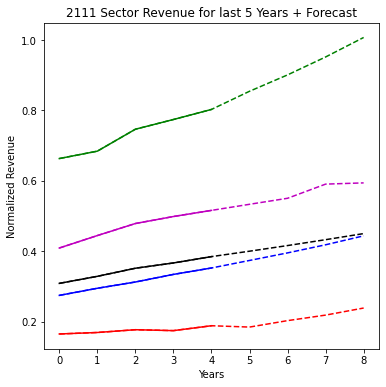

In [957]:
plt.figure(figsize = (6,6))
S, = plt.plot(range(len(Forecasted_Revenue['Sector_Rev'][0:5])),Forecasted_Revenue['Sector_Rev'][0:5],'k')
ps1, = plt.plot(range(len(Forecasted_Revenue['Green'][0:5])),Forecasted_Revenue['Green'][0:5],'g')
ps2, = plt.plot(range(len(Forecasted_Revenue['Blue'][0:5])),Forecasted_Revenue['Blue'][0:5],'b')
ps3, = plt.plot(range(len(Forecasted_Revenue['Magenta'][0:5])),Forecasted_Revenue['Magenta'][0:5],'m')
ps4, = plt.plot(range(len(Forecasted_Revenue['Red'][0:5])),Forecasted_Revenue['Red'][0:5],'r')

Sn, = plt.plot(range(len(Forecasted_Revenue['Sector_Rev'])),Forecasted_Revenue['Sector_Rev'],'k--')
ps1n, = plt.plot(range(len(Forecasted_Revenue['Green'])),Forecasted_Revenue['Green'],'g--')
ps2n, = plt.plot(range(len(Forecasted_Revenue['Blue'])),Forecasted_Revenue['Blue'],'b--')
ps3n, = plt.plot(range(len(Forecasted_Revenue['Magenta'])),Forecasted_Revenue['Magenta'],'m--')
ps4n, = plt.plot(range(len(Forecasted_Revenue['Red'])),Forecasted_Revenue['Red'],'r--')
#plt.legend([S,ps1,ps2,ps3,ps4],[ 'Sector '+str(n_borrowers), 'PS1', 'PS2', 'PS3', 'PS4'])
plt.title(Forecasted_Revenue['Sector'][0] + " Sector Revenue for last 5 Years + Forecast")
plt.xlabel("Years")

plt.ylabel("Normalized Revenue")
plt.show()

8 0.31
20 0.358
74 0.324
198 0.428
105 0.528
112 0.41
156 0.408


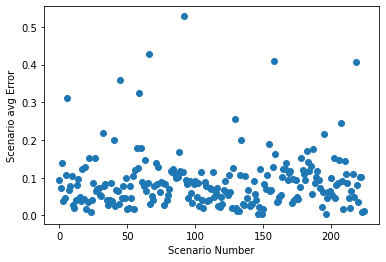

In [717]:
l = []
s = []
outlier = []
for i in scenario_error_dict.items():
    scenario,e = i
    l.append(e)
    if e > 0.3:
        print(scenario,e)
        outlier.append(scenario)
    #s.append(scenario)
    
plt.scatter(range(len(l)),l)
plt.xlabel("Scenario Number")
plt.ylabel("Scenario avg Error")
plt.show()

In [641]:
n = 0
total_companies = 0
total_n_companies = 0
for i in Scenario_NAICS_Dict.items():
    
    key,val = i
    Scenario_Data_Dict = Get_Sector_Data_Dict(Scenario_NAICS_Dict[key],CapIQ_data_dict_FY_N)
    total_companies += len(Scenario_Data_Dict) - 2 
    if len(Scenario_Data_Dict) > 21:
        n += 1
        total_n_companies += len(Scenario_Data_Dict) - 2
    
print(n)
print(total_n_companies)
print(total_companies)
        

/root/.cache/pypoetry/virtualenvs/oaknorth-ml-lib-QXhsOmlJ-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in true_divide
  app.launch_new_instance()


87
5516
6685


In [780]:
# def De_Normalize_Data(Forecast_Data_Dict):
    
#     Data_Set_DN = {}
#     Data_Set_DN['Sector'] = Forecast_Data_Dict['Sector']
    
#     Data_Set_DN['Sector Rev'] = []
#     for i in Forecast_Data_Dict['Sector Revenue']:
#         if i >= 0 and i < 0.1:
#             Data_Set_DN['Sector Rev'].append(int(i*5000000))
#         elif i >= 0.1 and i < 0.2:
#             Data_Set_DN['Sector Rev'].append(int(i*10000000))
#         elif i >= 0.2 and i < 0.3:
#             Data_Set_DN['Sector Rev'].append(int(i*50000000))
#         elif i >= 0.3 and i < 0.4:
#             Data_Set_DN['Sector Rev'].append(int(i*100000000))
#         elif i >= 0.4 and i < 0.5:
#             Data_Set_DN['Sector Rev'].append(int(i*500000000))
#         elif i >= 0.5 and i < 0.6:
#             Data_Set_DN['Sector Rev'].append(int(i*1000000000))
#         elif i >= 0.6 and i < 0.7:
#             Data_Set_DN['Sector Rev'].append(int(i*5000000000))
#         elif i >= 0.7 and i < 0.8:
#             Data_Set_DN['Sector Rev'].append(int(i*10000000000))
#         elif i >= 0.8 and i < 0.9:
#             Data_Set_DN['Sector Rev'].append(int(i*50000000000))
#         elif i >= 0.9:
#             Data_Set_DN['Sector Rev'].append(int(i*100000000000))
        
#     n = 0
#     for i in Forecast_Data_Dict.items():
#         if n > 1:
#             ID,data = i

#             Data_Set_DN[ID] = {'Company Revenue': [], 'Actual':[], 'Computed Forecast' :[]}

#             for j in data.items():
#                 name,val = j
#                 for i in val:
#                     if i >= 0 and i < 0.1:
#                         Data_Set_DN[ID][name].append(int(i*5000000))
#                     elif i >= 0.1 and i < 0.2:
#                         Data_Set_DN[ID][name].append(int(i*10000000))
#                     elif i >= 0.2 and i < 0.3:
#                         Data_Set_DN[ID][name].append(int(i*50000000))
#                     elif i >= 0.3 and i < 0.4:
#                         Data_Set_DN[ID][name].append(int(i*100000000))
#                     elif i >= 0.4 and i < 0.5:
#                         Data_Set_DN[ID][name].append(int(i*500000000))
#                     elif i >= 0.5 and i < 0.6:
#                         Data_Set_DN[ID][name].append(int(i*1000000000))
#                     elif i >= 0.6 and i < 0.7:
#                         Data_Set_DN[ID][name].append(int(i*5000000000))
#                     elif i >= 0.7 and i < 0.8:
#                         Data_Set_DN[ID][name].append(int(i*10000000000))
#                     elif i >= 0.8 and i < 0.9:
#                         Data_Set_DN[ID][name].append(int(i*50000000000))
#                     elif i >= 0.9:
#                         Data_Set_DN[ID][name].append(int(i*100000000000))
        
#         n += 1
                
#     return Data_Set_DN
    
    
# Forecast_Data_Dict_DN = De_Normalize_Data(Forecast_Data_Dict)
# for i in Forecast_Data_Dict_DN.items():
#     print(i)